In [1]:
import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from flow_matching.supervised.odes_sdes import CFGVectorFieldODE
from flow_matching.supervised.simulators import EulerSimulator
from flow_matching.supervised.alphas_betas import LinearAlpha, LinearBeta
from flow_matching.supervised.prob_paths import GaussianConditionalProbabilityPath
from flow_matching.whar.sampler import WHARSamplerRAW, stft_transform_combine
from flow_matching.whar.vae import SpectrogramVAE
from flow_matching.whar.latent_vector_field import FlowNetBackbone
from flow_matching.whar.latent_vector_field_mhsa import FlowNetBackboneAxial
from flow_matching.latent.training_flow import LatentFlowTrainer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sampler = WHARSamplerRAW(transform=stft_transform_combine)

Creating config hash...
Checking download...
Download exists.
Checking sessions...
Sessions exist.
Validating common format...
[########################################] | 100% Completed | 848.33 ms
Common format validated.
Checking windowing...
Loading config hash...
Windowing exists.
subject_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
activity_ids: [0 1 2 3 4 5]
train: 7046 | val: 782 | test: 1671
Postprocessing...


Loading windows: 100%|██████████| 9499/9499 [00:07<00:00, 1287.81it/s]


Getting normalization parameters...
Loading config hash...
Creating normalization parameters hash...
Loading normalization parameters hash...


Loading samples: 100%|██████████| 9499/9499 [00:02<00:00, 4074.00it/s]


In [4]:
shape = sampler.get_shape()
num_channels = shape[1]
print(shape)

num_classes = len(sampler.dataset.get_class_weights(sampler.train_loader).keys())
print(num_classes)

[18, 32, 32]
6


In [5]:
vae = SpectrogramVAE().to(device)
vae.load_state_dict(torch.load("vae.pt"))

path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=[64, 4, 4],
    alpha=LinearAlpha(),
    beta=LinearBeta(),
).to(device)

vf = FlowNetBackboneAxial(num_classes=num_classes).to(device)

trainer = LatentFlowTrainer(
    path=path, model=vf, vae=vae, eta=0.1, null_class=num_classes
)

In [ ]:
trainer.train(num_epochs=2000, device=device, lr=1e-3, batch_size=64)

In [ ]:
torch.save(vf.state_dict(), "latent_vf.pt")

In [ ]:
vf.load_state_dict(torch.load("latent_vf.pt"))

<All keys matched successfully>

100%|██████████| 99/99 [00:00<00:00, 258.11it/s]


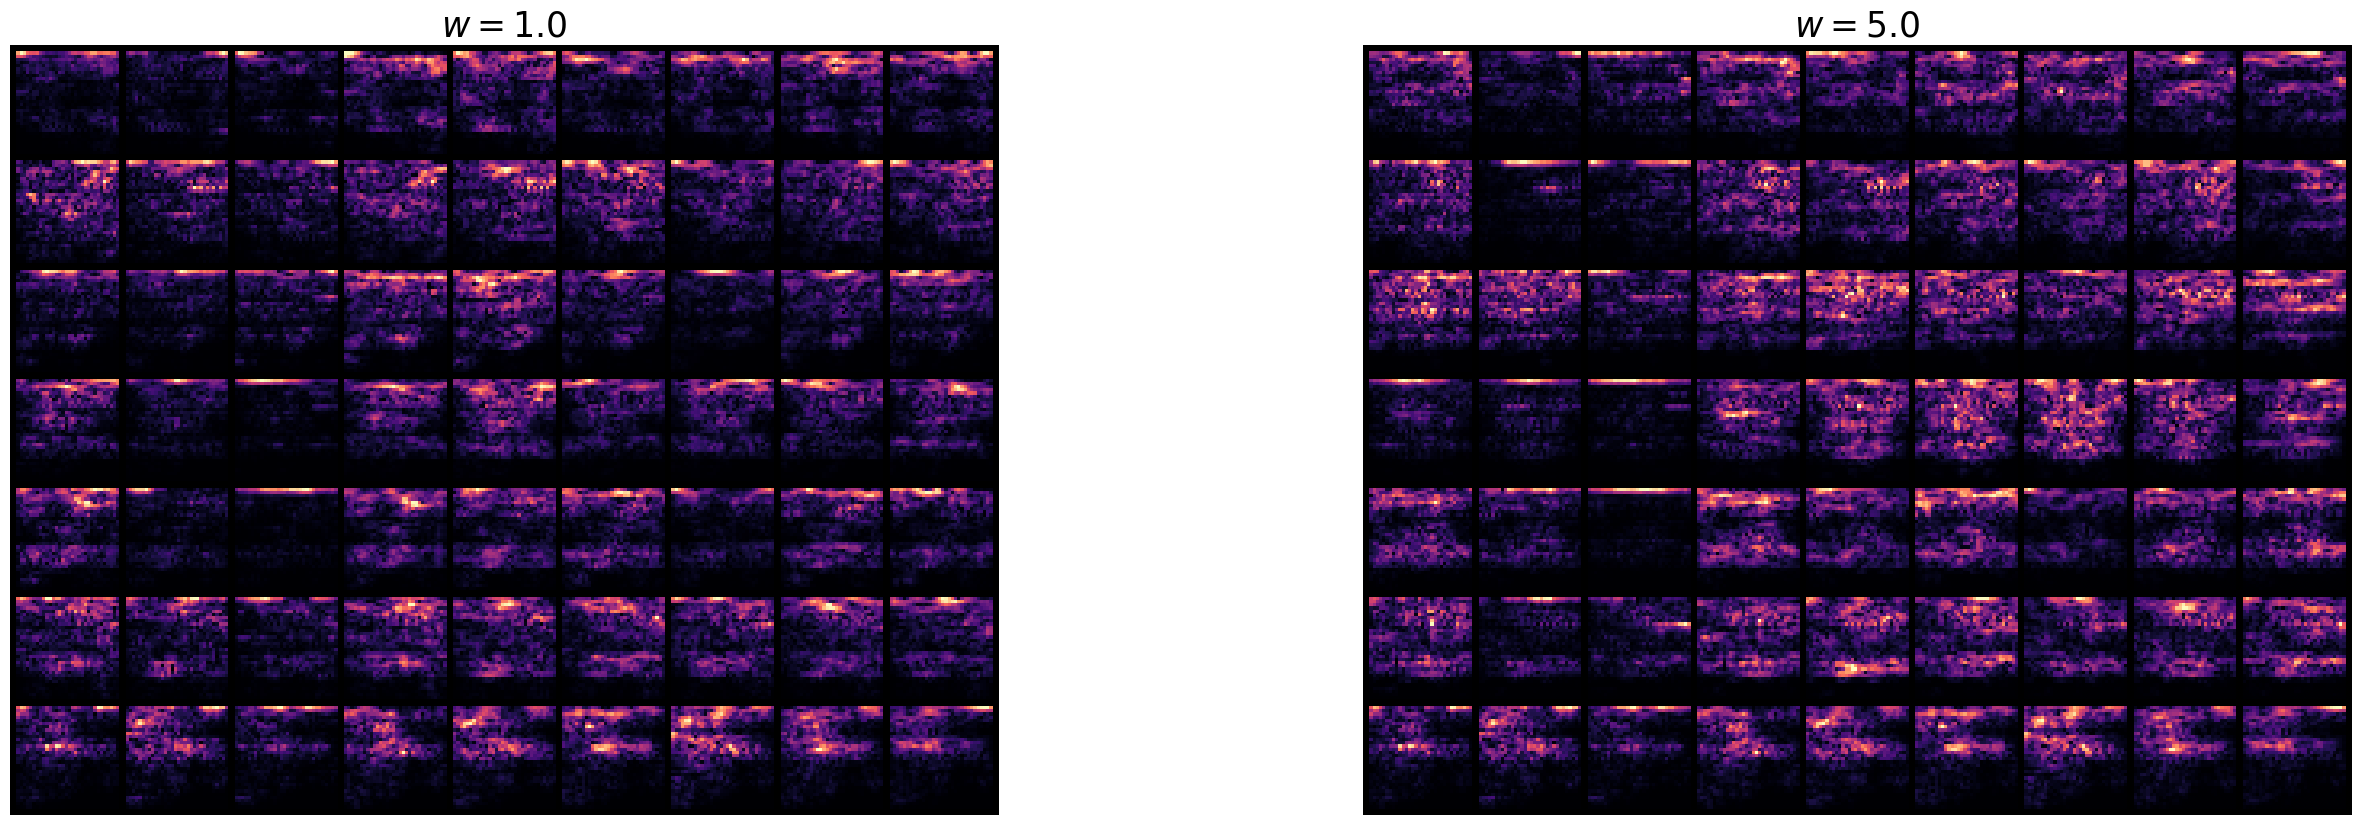

In [ ]:
import numpy as np


num_timesteps = 100
guidance_scales = [1.0, 5.0]

fig, axes = plt.subplots(
    1, len(guidance_scales), figsize=(num_channels // 2 * len(guidance_scales), 10)
)

# Sample initial conditions (+1 for null class)
y = torch.arange(num_classes + 1).to(device)

num_samples = y.shape[0]
x0, _ = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(vf, guidance_scale=w, null_class=num_classes)
    simulator = EulerSimulator(ode)

    # Simulate
    ts = (
        torch.linspace(0, 1, num_timesteps)
        .view(1, -1, 1, 1, 1)
        .expand(num_samples, -1, 1, 1, 1)
        .to(device)
    )

    x1 = simulator.simulate(x0, ts, y=y)

    x1 = vae.decode(x1)

    B, C, H, W = x1.shape
    x1 = x1.view(B, C // 2, 2, H, W)
    x1_mag = torch.sqrt(
        x1[:, :, 0] ** 2 + x1[:, :, 1] ** 2 + 1e-8
    )  # shape: (B, C//2, H, W)

    # Flatten batch and channel dims to (B * (C//2), H, W)
    x1_mag_flat = x1_mag.view(-1, H, W).cpu().numpy()

    # Normalize each image to [0,1] for colormap
    x1_min = x1_mag_flat.min(axis=(1, 2), keepdims=True)
    x1_max = x1_mag_flat.max(axis=(1, 2), keepdims=True)
    x1_norm = (x1_mag_flat - x1_min) / (x1_max - x1_min + 1e-8)

    cmap = plt.get_cmap("magma")
    heatmaps = [
        cmap(img)[:, :, :3] for img in x1_norm
    ]  # apply colormap and drop alpha channel
    heatmaps = np.stack(heatmaps, axis=0)

    # Convert to tensor and rearrange to (batch, channels, height, width)
    heatmaps_t = torch.tensor(heatmaps).permute(0, 3, 1, 2)

    # Create grid: nrow = C//2 (number of channels per sample)
    grid = make_grid(heatmaps_t, nrow=(C // 2), padding=2)

    axes[idx].imshow(grid.permute(1, 2, 0).cpu())
    axes[idx].axis("off")
    axes[idx].set_title(f"$w={w:.1f}$", fontsize=25)
plt.show()